In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

train_data = pd.read_csv("train.csv")

test_data = pd.read_csv("test.csv")


In [ ]:
test_data.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


In [ ]:
train_data['country'].fillna(train_data['country'].mode()[0], inplace = True)
train_data['store'].fillna(train_data['store'].mode()[0] , inplace = True)
train_data['product'].fillna(train_data['product'].mode()[0] , inplace= True)

train_data['date'] = pd.to_datetime(train_data['date'], errors='coerce')
train_data['date'] = train_data['date'].fillna(train_data['date'].min())
train_data['date'] = train_data['date'].map(pd.Timestamp.toordinal)


<ipython-input-93-a05fe3828418>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['country'].fillna(train_data['country'].mode()[0], inplace = True)
<ipython-input-93-a05fe3828418>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

In [ ]:
labelencoder = LabelEncoder()
train_data['country'] = labelencoder.fit_transform(train_data['country'])
train_data['product'] = labelencoder.fit_transform(train_data['product'])
train_data['store'] = labelencoder.fit_transform(train_data['store'])

In [ ]:


#min_length = min(len(X), len(y))
#X = X[:min_length]
#y = y[:min_length]
print(train_data['num_sold'].isnull().sum())  # Check for NaNs in the target column

train_data['num_sold'].fillna(train_data['num_sold'].mean(), inplace=True)


8871


<ipython-input-95-ef1238a93286>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['num_sold'].fillna(train_data['num_sold'].mean(), inplace=True)


In [ ]:
correlation_matrix = train_data.corr()

# Extract correlation with the target variable ('num_sold')
correlation_with_target = correlation_matrix['num_sold']

print("Correlation of each feature with 'num_sold':")
print(correlation_with_target)

Correlation of each feature with 'num_sold':
id         -0.040000
date       -0.040068
country     0.126391
store       0.233647
product     0.004082
num_sold    1.000000
Name: num_sold, dtype: float64


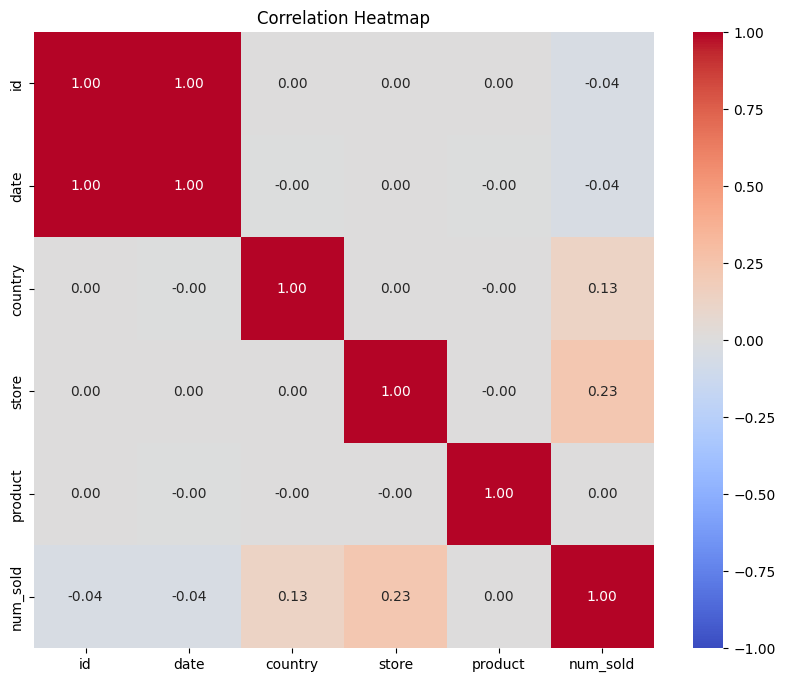

In [ ]:
# Plot a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",vmin=-1,vmax=1)
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
X = train_data.drop(['num_sold','date','product'],axis=1).values
y = train_data['num_sold'].values


In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X,y,random_state=42,test_size=0.2)
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
assert not np.isnan(X_train).any(), "Found NaN in X_train"
assert not np.isinf(X_train).any(), "Found Inf in X_train"
assert not np.isnan(y_train).any(), "Found NaN in y_train"
assert not np.isinf(y_train).any(), "Found Inf in y_train"

In [ ]:
class StickerSales(Dataset):
  def __init__(self,features,labels):
    self.features =torch.tensor(features , dtype = torch.float32)
    self.labels = torch.tensor(labels , dtype= torch.float32)

  def __len__(self):
    return len(self.features)

  def __getitem__(self , idx):
    return self.features[idx] , self.labels[idx]


train_datasets = StickerSales(X_train,y_train)
val_datasets = StickerSales(X_val , y_val)

train_loader = DataLoader(train_datasets,batch_size = 32 , shuffle = True)
val_loader = DataLoader(val_datasets,batch_size = 32 , shuffle=False)

In [ ]:
class StickerModel(nn.Module):
    def __init__(self):
        super(StickerModel, self).__init__()
        self.fc1 = nn.Linear(3, 16)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(16, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 256)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(256, 1024)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(1024, 256)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(256, 64)
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(64, 16)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(16, 4)
        self.relu8 = nn.ReLU()
        self.fc9 = nn.Linear(4, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.relu4(self.fc4(x))
        x = self.relu5(self.fc5(x))
        x = self.relu6(self.fc6(x))
        x = self.relu7(self.fc7(x))
        x = self.relu8(self.fc8(x))
        x = self.fc9(x)
        return x


model = StickerModel()
print(model)


StickerModel(
  (fc1): Linear(in_features=3, out_features=16, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=16, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=256, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=256, out_features=1024, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=1024, out_features=256, bias=True)
  (relu5): ReLU()
  (fc6): Linear(in_features=256, out_features=64, bias=True)
  (relu6): ReLU()
  (fc7): Linear(in_features=64, out_features=16, bias=True)
  (relu7): ReLU()
  (fc8): Linear(in_features=16, out_features=4, bias=True)
  (relu8): ReLU()
  (fc9): Linear(in_features=4, out_features=1, bias=True)
)


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr = 0.001 )

In [ ]:
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for features, labels in train_loader:

        if torch.isnan(features).any() or torch.isinf(features).any():
            print("Found NaN or Inf in features")
        if torch.isnan(labels).any() or torch.isinf(labels).any():
            print("Found NaN or Inf in labels")


        outputs = model(features).squeeze(1)
        loss = criterion(outputs, labels)


        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()


    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, labels in val_loader:
            outputs = model(features).squeeze(1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()


    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


Epoch 1/50, Train Loss: 261393.9274, Val Loss: 231418.1486
Epoch 2/50, Train Loss: 232300.7745, Val Loss: 229000.6715
Epoch 3/50, Train Loss: 231887.9611, Val Loss: 229416.1184
Epoch 4/50, Train Loss: 230582.0776, Val Loss: 232248.5275
Epoch 5/50, Train Loss: 230606.8399, Val Loss: 233427.4144
Epoch 6/50, Train Loss: 230084.0395, Val Loss: 227600.4030
Epoch 7/50, Train Loss: 229670.6814, Val Loss: 241113.1916
Epoch 8/50, Train Loss: 229695.3989, Val Loss: 227923.1071
Epoch 9/50, Train Loss: 229073.1608, Val Loss: 228526.6969
Epoch 10/50, Train Loss: 229066.2135, Val Loss: 227726.1439
Epoch 11/50, Train Loss: 229208.6156, Val Loss: 230443.7871
Epoch 12/50, Train Loss: 229068.0226, Val Loss: 229112.2204
Epoch 13/50, Train Loss: 228253.0867, Val Loss: 229095.5801
Epoch 14/50, Train Loss: 228136.9647, Val Loss: 229632.3057
Epoch 15/50, Train Loss: 227998.5326, Val Loss: 226521.3128
Epoch 16/50, Train Loss: 228100.5687, Val Loss: 231835.7598
Epoch 17/50, Train Loss: 227927.6610, Val Loss: 2

In [ ]:


model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for features, labels in val_loader:
        outputs = model(features).squeeze()
        y_pred.extend(outputs.numpy())
        y_true.extend(labels.numpy())

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_true, y_pred)
print(f"Validation MSE: {mse:.4f}")

r2 = r2_score(y_true, y_pred)
print(f"Validation R2: {r2:.4f}")




In [ ]:

test_data['country'].fillna(test_data['country'].mode()[0], inplace=True)
test_data['store'].fillna(test_data['store'].mode()[0], inplace=True)


labelencoder = LabelEncoder()
test_data['country'] = labelencoder.fit_transform(test_data['country'])
test_data['store'] = labelencoder.fit_transform(test_data['store'])


X_test = test_data.drop(['date', 'product'], axis=1).values
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)


model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor).squeeze().detach().numpy()


submission = pd.read_csv('sample_submission.csv')
submission['num_sold'] = test_preds
submission.to_csv('submission1.csv', index=False)
